In [1]:
# models
from n2v import N2VModel
from s2v import S2VModel

# utility
import numpy as np
import argparse
import matplotlib.pyplot as plt
from util import data_util as du
from util import vis
from util import parameters
import main

# arguments
params = parameters.get_parameters(notebook=True)

In [ ]:
# params.model_type = 's2v'
main.run(params)

## Select run

Select run to visualise

In [2]:
import os

class RunData:
    def __init__(self, selected_run):
        self.data_path = os.path.join('results', selected_run, 'data')
        self.model_output = os.path.join('results', selected_run, 'model_output')
        self.plots_path = os.path.join('results', selected_run, 'plots')

        # load all data
        self.bootstrap_preds_all = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_all.npy'))
        self.bootstrap_preds_missing = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_missing.npy'))
        self.bootstrap_preds_spurious = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_spurious.npy'))
        self.fit_negative_samples = du.read_pickle(os.path.join(self.data_path, 'fit_negative_samples.npy'))
        self.missing = du.read_pickle(os.path.join(self.data_path, 'missing.npy'))
        self.score_negative_samples = du.read_pickle(os.path.join(self.data_path, 'score_negative_samples.npy'))
        self.spurious = du.read_pickle(os.path.join(self.data_path, 'spurious.npy'))
        self.train_data = du.load_edge_list(os.path.join(self.data_path, 'train_data.edgelist'))

        # load model
        self.model = du.read_pickle(os.path.join(self.model_output, 'model.bin'))

available_runs = sorted(os.listdir('results/'))
selected_run = available_runs[-1]
rd = RunData(selected_run)

## Loading Data
Show true data and noisy data for current run

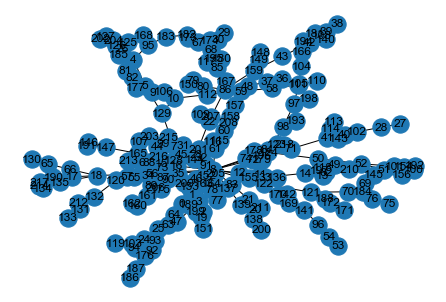

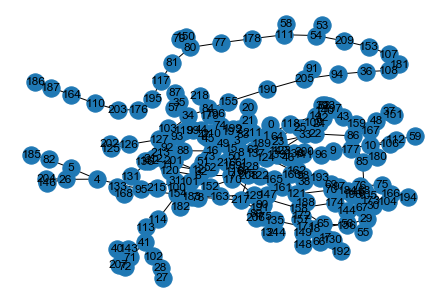

In [3]:
from util import vis
# show data
data = du.load_edge_list(params.input_data)
v = vis.vis_graph(data)
plt.show(v)

v = vis.vis_graph(rd.train_data)
plt.show(v)

## Training the model
The node2vec model is trained, this gives us the node embeddings to determine similarity between nodes, and more importantly, the edge embeddings. 

## Edge Embeddings
As we can see in the visualisations below, embeddings are defined for all possible edges, not just edges that exist in the graph. However, directionality is discarded after embedding. Due to the nature of the implemented edge embeddings, an edge from node 1 to node 2 will output the same edge embedding as an edge from node 2 to node 1. For example, the Hadamard embedding will multiply the node embeddings of node 1 and node 2 together. More info at this link: https://github.com/eliorc/node2vec/issues/36

In [ ]:
print('Nodes')
fig2dnodes = vis.vis_embeddings(rd.model.nodes)
plt.show()

print('Edges')
edge_labels = du.construct_embedding_labels(data, rd.model.ee_kv)
embeddings2dedges = du.vis_edge_embeddings(data, rd.model.ee_kv.vectors, edge_labels)
plt.show()

## plots
Classify points

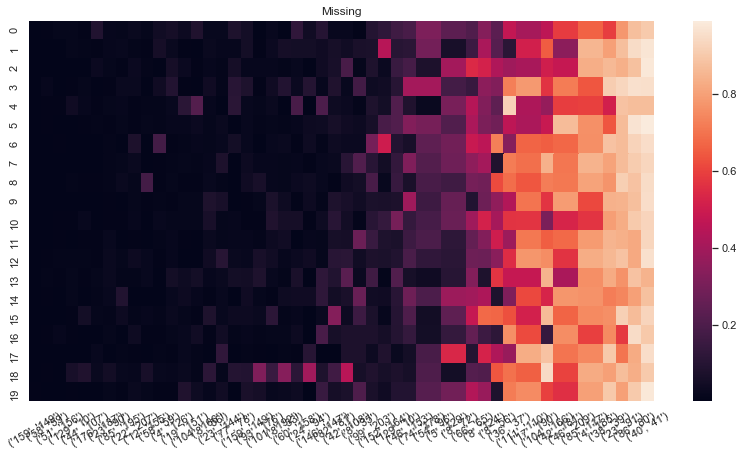

In [4]:
import pandas as pd

# missing
# set constants
num_runs = len(rd.bootstrap_preds_missing)
num_nodes = len(rd.bootstrap_preds_missing[0])

# unpack values
all_runs_missing_preds, missing_edge_names, _ = du.unpack_values(rd.bootstrap_preds_missing)
all_runs_missing_preds = all_runs_missing_preds[:, :, 1]

# convert edge labels for heatmap
missing_edge_names = du.tuple2edge_str(missing_edge_names)

# sort columns
all_runs_missing_preds = pd.DataFrame(data=all_runs_missing_preds, columns=missing_edge_names)
totals = all_runs_missing_preds.sum(axis=0)
all_runs_missing_preds = all_runs_missing_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)

# plot heatmap
fig = vis.plot_heatmap(all_runs_missing_preds, fname=f'{params.model_type}_missing.png', dirname=rd.plots_path, xticklabels=missing_edge_names, figsize=(14,7))
plt.title('Missing')
plt.show(fig)

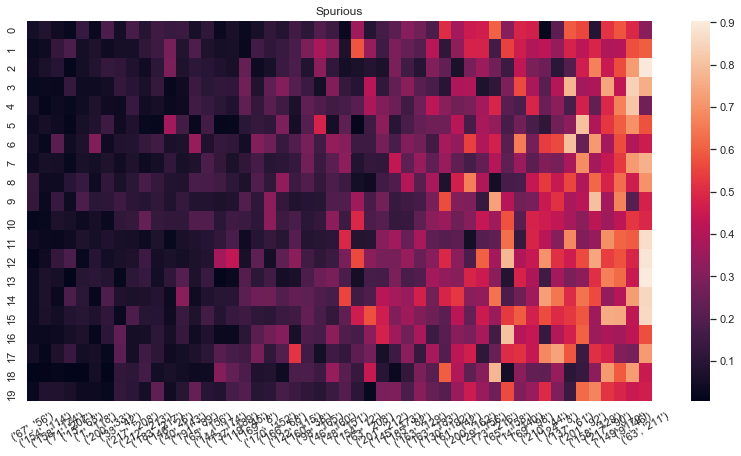

In [5]:
# spurious
# set constants
num_runs = len(rd.bootstrap_preds_spurious)
num_nodes = len(rd.bootstrap_preds_spurious[0])

# unpack values
all_runs_spurious_preds, spurious_edge_names, _ = du.unpack_values(rd.bootstrap_preds_spurious)
all_runs_spurious_preds = all_runs_spurious_preds[:, :, 0]

# convert edge labels for heatmap
spurious_edge_names = du.tuple2edge_str(spurious_edge_names)

# sort columns
all_runs_spurious_preds = pd.DataFrame(data=all_runs_spurious_preds, columns=spurious_edge_names)
totals = all_runs_spurious_preds.sum(axis=0)
all_runs_spurious_preds = all_runs_spurious_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)

# plot heatmap
fig = vis.plot_heatmap(all_runs_spurious_preds, fname=f'{params.model_type}_spurious.png', dirname=rd.plots_path, xticklabels=spurious_edge_names, figsize=(14,7))
plt.title('Spurious')
plt.show(fig)

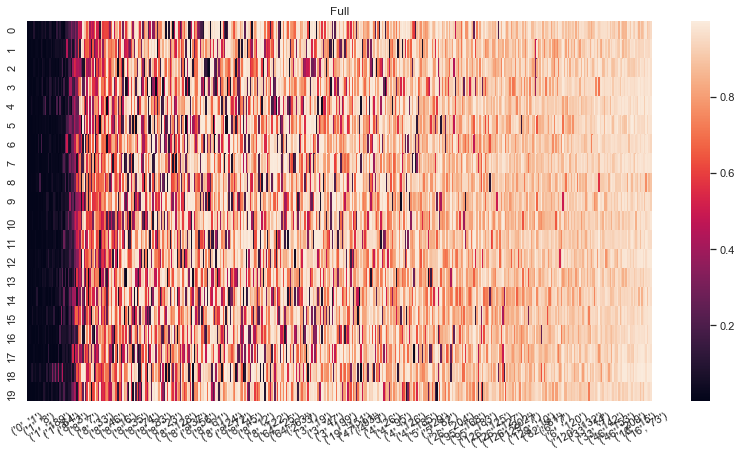

In [7]:
# full
# set constants
num_runs = len(rd.bootstrap_preds_all)
num_nodes = len(rd.bootstrap_preds_all[0])

# unpack values
all_runs_full_preds, full_edge_names, full_labels = du.unpack_values(rd.bootstrap_preds_all)

# filter predictions by label
all_runs_full_preds = du.filter_preds_by_label(all_runs_full_preds, full_labels)

# convert edge labels for heatmap
full_edge_names = du.tuple2edge_str(full_edge_names)

# sort columns
all_runs_full_preds = pd.DataFrame(data=all_runs_full_preds, columns=full_edge_names)
totals = all_runs_full_preds.sum(axis=0)
all_runs_full_preds = all_runs_full_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)

# plot heatmap
fig = vis.plot_heatmap(all_runs_full_preds, fname=f'{params.model_type}_full.png', dirname=rd.plots_path, xticklabels=full_edge_names, figsize=(14,7))
plt.title('Full')
plt.show(fig)

In [35]:
thresh = 0.5
# noisy samples
print("NOISY SAMPLES")

# MISSING
print("MISSING")
num_runs = len(rd.bootstrap_preds_missing)
num_nodes = len(rd.bootstrap_preds_missing[0])
all_runs_missing_preds, missing_edge_names, _ = du.unpack_values(rd.bootstrap_preds_missing)
# probablistic
correct = np.sum(all_runs_missing_preds[:, :, 1])
total = num_runs * num_nodes
ratio = correct / float(total)
# thresholded
true_positive = np.sum(all_runs_missing_preds[:, :, 1] > thresh) 
false_negative = total - true_positive
print('correct: ', correct, ', total mass:', total, ', ratio: ', ratio)

# SPURIOUS
print("SPURIOUS")
num_runs = len(rd.bootstrap_preds_spurious)
num_nodes = len(rd.bootstrap_preds_spurious[0])
all_runs_spurious_preds, spurious_edge_names, _ = du.unpack_values(rd.bootstrap_preds_spurious)
# probablistic
correct = np.sum(all_runs_spurious_preds[:, :, 0])
total = num_runs * num_nodes
ratio = correct / float(total)
# thresholded
true_negative = np.sum(all_runs_spurious_preds[:, :, 0] > thresh) 
false_positive = total - true_negative
print('correct: ', correct, ', total mass:', total, ', ratio: ', ratio)

print('tp', true_positive, 'tn', true_negative, 'fp', false_positive, 'fn', false_negative)


NOISY SAMPLES
MISSING
correct:  236.6276900645909 , total mass: 1000 , ratio:  0.2366276900645909
SPURIOUS
correct:  240.80600989847562 , total mass: 1000 , ratio:  0.24080600989847561
tp 223 tn 109 fp 891 fn 777


In [38]:
# FULL
print("FULL")
num_runs = len(rd.bootstrap_preds_all)
num_nodes = len(rd.bootstrap_preds_all[0])

# unpack values
all_runs_full_preds, full_edge_names, full_labels = du.unpack_values(rd.bootstrap_preds_all)

# filter predictions by label
filtered = du.filter_preds_by_label(all_runs_full_preds, full_labels)

# probablistic
correct = np.sum(filtered)
total = num_runs * num_nodes
ratio = correct / float(total)
# thresholded
true_negative = np.sum(filtered > thresh) 
false_positive = total - true_negative
print('correct: ', correct, ', total mass:', total, ', ratio: ', ratio)

print('tp', true_positive, 'tn', true_negative, 'fp', false_positive, 'fn', false_negative)

FULL
correct:  6480.282225336221 , total mass: 8720 , ratio:  0.7431516313458969
tp 223 tn 7044 fp 1676 fn 777
